In [68]:
from params import *
from prepare_data import *
from model import *
from eval import *
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score, accuracy_score
import seaborn as sns
from to_json import *

In [20]:
params = get_params()
DATASET_DIR = params['DATASET_DIR']
BATCH_SIZE = params['BATCH_SIZE']
AUDIO_DURATION = params['AUDIO_DURATION']
SAMPLING_RATE = params['SAMPLING_RATE']
MODEL_FILENAME = params['MODEL_FILENAME']
EPOCHS = params['EPOCHS']
N_MELS = params['N_MELS']
N_CLASSES = params['N_CLASSES']

train_wav_list, train_label_list = parse_data_list(params, "Train")
train_ds = generate_dataset(params, train_wav_list, train_label_list)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

In [21]:
# Function to visualize audio data
def visualize_audio_dataset(dataset):
    for audio, label in dataset:
        # Assuming 'audio' is a numpy array containing audio data
        audio = np.squeeze(audio.numpy())  # Ensure 1D array

        sr = SAMPLING_RATE

        # Plot waveform
        plt.figure(figsize=(12, 4))
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f'Waveform - Label: {label}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()

        # Plot spectrogram
        plt.figure(figsize=(12, 4))
        spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
        librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram - Label: {label}')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()

Load the Data from the JSON Files

In [34]:
# Load the data from json files
X_train, y_train, X_val, y_val, X_test, y_test = load_data("json_data/train.json", 
                                                           "json_data/val.json", 
                                                           "json_data/test.json")

In [35]:
# Convert the arrays to 3D
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [58]:
y_train.shape

(60855,)

Build Model

In [55]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

model = models.Sequential()

# 1st conv layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model.add(layers.BatchNormalization())

# 2nd conv layer 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model.add(layers.BatchNormalization())

# 3rd conv layer
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
model.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model.add(layers.BatchNormalization())

# Flatten output
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))

# Output layer
model.add(layers.Dense(13, activation='softmax'))

Compile Model

In [60]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 106, 11, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 53, 6, 32)         0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 53, 6, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 51, 4, 32)         9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 2, 32)         0         
 g2D)                                                            
                                                      

In [64]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_FILENAME, monitor="val_accuracy", save_best_only=True)
callbacks = [earlystopping_callback, checkpoint_callback]

history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks)

Epoch 1/100
1902/1902 [==============================] - 30s 16ms/step - loss: 1.2785 - accuracy: 0.5460 - val_loss: 1.4453 - val_accuracy: 0.5298
Epoch 2/100
   1/1902 [..............................] - ETA: 30s - loss: 1.6372 - accuracy: 0.4688

C:\Users\reece\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1902/1902 [==============================] - 31s 16ms/step - loss: 1.1749 - accuracy: 0.5832 - val_loss: 1.3045 - val_accuracy: 0.5506
Epoch 3/100
1902/1902 [==============================] - 31s 16ms/step - loss: 1.1132 - accuracy: 0.6030 - val_loss: 1.2269 - val_accuracy: 0.5912
Epoch 4/100
1902/1902 [==============================] - 34s 18ms/step - loss: 1.0680 - accuracy: 0.6203 - val_loss: 1.2864 - val_accuracy: 0.5584
Epoch 5/100
1902/1902 [==============================] - 31s 16ms/step - loss: 1.0326 - accuracy: 0.6292 - val_loss: 1.3707 - val_accuracy: 0.5621
Epoch 6/100
1902/1902 [==============================] - 30s 16ms/step - loss: 1.0088 - accuracy: 0.6387 - val_loss: 1.2883 - val_accuracy: 0.5782
Epoch 7/100
1902/1902 [==============================] - 30s 16ms/step - loss: 0.9882 - accuracy: 0.6438 - val_loss: 1.3147 - val_accuracy: 0.5826
Epoch 8/100
1902/1902 [==============================] - 31s 16ms/step - loss: 0.9673 - accuracy: 0.6516 - val_loss: 1.1700 - val_

Evaluate the Model

In [67]:
# Check the scores
y_pred = model.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)
print (classification_report(y_test, y_pred))

241/241 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.76      0.51      0.61       591
           1       0.42      0.56      0.48       593
           2       0.79      0.72      0.76       585
           3       0.37      0.41      0.39       592
           4       0.60      0.84      0.70       596
           5       0.83      0.71      0.77       600
           6       0.53      0.55      0.54       581
           7       0.46      0.42      0.44       581
           8       0.61      0.35      0.45       598
           9       0.75      0.85      0.80       600
          10       0.63      0.72      0.67       579
          11       0.59      0.65      0.62       595
          12       0.56      0.42      0.48       596

    accuracy                           0.60      7687
   macro avg       0.61      0.60      0.59      7687
weighted avg       0.61      0.60      0.59      7687



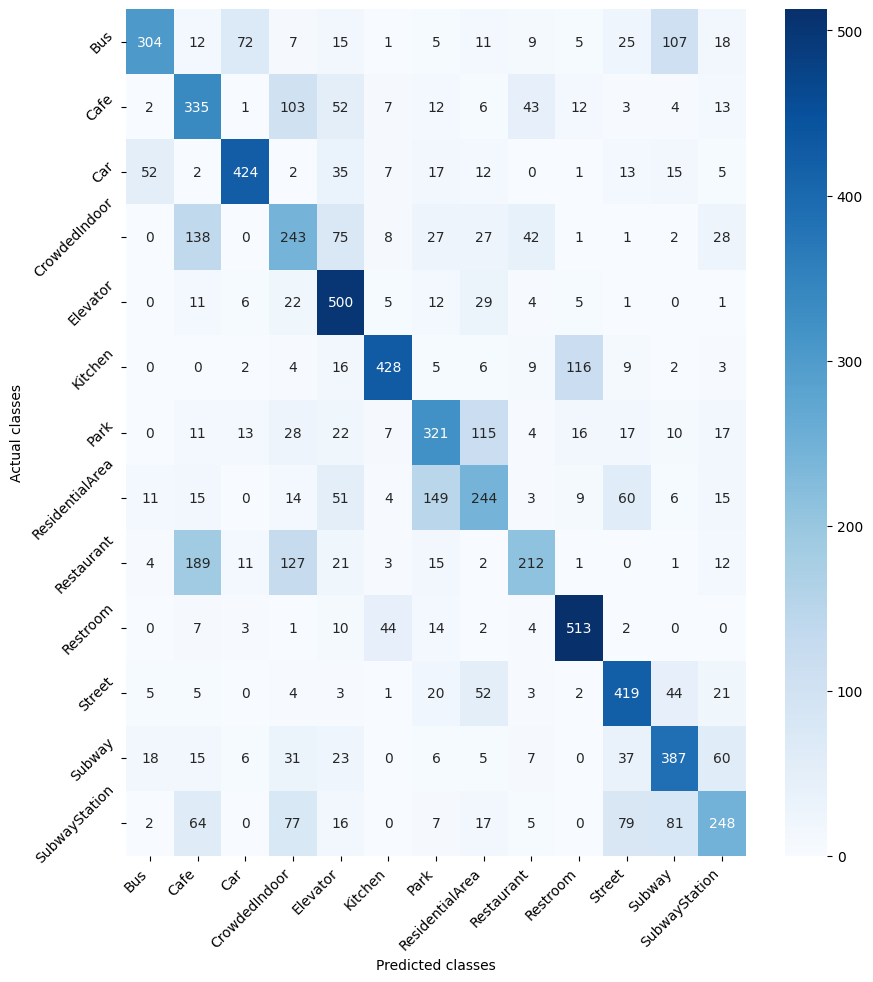

In [69]:
# Create the confusion matrix
labels = os.listdir(os.path.join(DATASET_DIR, "Train"))
labels.sort()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,11))
ax = sns.heatmap(cm, annot=True, fmt='d' ,cmap='Blues')

ax.set_xlabel('Predicted classes')
ax.set_ylabel('Actual classes');

ax.xaxis.set_ticklabels(labels, rotation=45, ha='right', minor=False)
ax.yaxis.set_ticklabels(labels, rotation=45, ha='right', minor=False)

plt.show()

# Same Model, but Crowded Indoor removed

In [73]:
class_label_to_remove = 3

# Create a boolean mask where True corresponds to elements with the specified class label
mask = (y_train == class_label_to_remove)

# Invert the mask to keep the elements that do not have the specified class label
X_train = X_train[~mask]
y_train = y_train[~mask]

mask = (y_val == class_label_to_remove)
X_val = X_val[~mask]
y_val = y_val[~mask]

mask = (y_test == class_label_to_remove)
X_test = X_test[~mask]
y_test = y_test[~mask]

In [80]:
# Adjust all labels > 3 to 1 minus the current
condition = y_train > 3
y_train[condition] = y_train[condition] - 1

condition = y_val > 3
y_val[condition] = y_val[condition] - 1

condition = y_test > 3
y_test[condition] = y_test[condition] - 1

Build Model

In [74]:
# Same model as the first one
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

model2 = models.Sequential()

# 1st conv layer
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model2.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model2.add(layers.BatchNormalization())

# 2nd conv layer 
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model2.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model2.add(layers.BatchNormalization())

# 3rd conv layer
model2.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
model2.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model2.add(layers.BatchNormalization())

# Flatten output
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.3))

# Output layer
model2.add(layers.Dense(12, activation='softmax'))

Compile the Model

In [77]:
opt2 = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt2, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 106, 11, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 53, 6, 32)         0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Ba  (None, 53, 6, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 51, 4, 32)         9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 2, 32)         0         
 ng2D)                                                           
                                                      

Train Model

In [81]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_FILENAME, monitor="val_accuracy", save_best_only=True)
callbacks = [earlystopping_callback, checkpoint_callback]

history2 = model2.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks)

Epoch 1/100
1756/1756 [==============================] - 30s 17ms/step - loss: 1.4002 - accuracy: 0.5038 - val_loss: 1.2862 - val_accuracy: 0.5711
Epoch 2/100
   4/1756 [..............................] - ETA: 29s - loss: 1.1097 - accuracy: 0.6484

C:\Users\reece\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1756/1756 [==============================] - 28s 16ms/step - loss: 1.1515 - accuracy: 0.5908 - val_loss: 1.4412 - val_accuracy: 0.5546
Epoch 3/100
1756/1756 [==============================] - 27s 16ms/step - loss: 1.0512 - accuracy: 0.6270 - val_loss: 1.7346 - val_accuracy: 0.4921
Epoch 4/100
1756/1756 [==============================] - 28s 16ms/step - loss: 1.0020 - accuracy: 0.6441 - val_loss: 1.2551 - val_accuracy: 0.6129
Epoch 5/100
1756/1756 [==============================] - 27s 15ms/step - loss: 0.9596 - accuracy: 0.6575 - val_loss: 1.1317 - val_accuracy: 0.6342
Epoch 6/100
1756/1756 [==============================] - 27s 16ms/step - loss: 0.9217 - accuracy: 0.6723 - val_loss: 1.4213 - val_accuracy: 0.5724
Epoch 7/100
1756/1756 [==============================] - 27s 16ms/step - loss: 0.9002 - accuracy: 0.6797 - val_loss: 1.0911 - val_accuracy: 0.6569
Epoch 8/100
1756/1756 [==============================] - 28s 16ms/step - loss: 0.8736 - accuracy: 0.6865 - val_loss: 1.2359 - val_

Evaluate the Model

In [83]:
y_pred = model2.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)
print (classification_report(y_test, y_pred))

222/222 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       591
           1       0.59      0.54      0.56       593
           2       0.78      0.72      0.75       585
           3       0.66      0.86      0.75       596
           4       0.79      0.79      0.79       600
           5       0.58      0.58      0.58       581
           6       0.53      0.39      0.45       581
           7       0.68      0.53      0.60       598
           8       0.83      0.79      0.81       600
           9       0.69      0.62      0.66       579
          10       0.51      0.77      0.62       595
          11       0.59      0.61      0.60       596

    accuracy                           0.65      7095
   macro avg       0.66      0.65      0.65      7095
weighted avg       0.66      0.65      0.65      7095



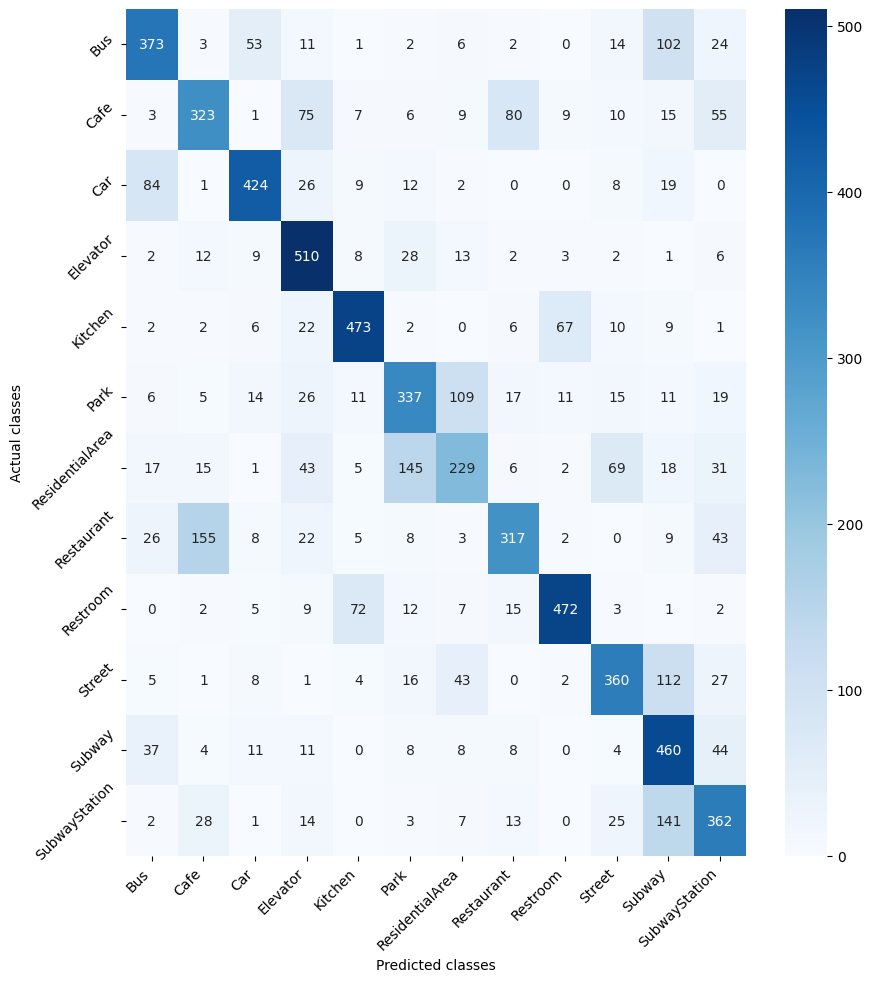

In [88]:
# Create the confusion matrix
labels = os.listdir(os.path.join(DATASET_DIR, "Train"))
labels.sort()
labels.remove('CrowdedIndoor')

cm2 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,11))
ax = sns.heatmap(cm2, annot=True, fmt='d' ,cmap='Blues')

ax.set_xlabel('Predicted classes')
ax.set_ylabel('Actual classes');

ax.xaxis.set_ticklabels(labels, rotation=45, ha='right', minor=False)
ax.yaxis.set_ticklabels(labels, rotation=45, ha='right', minor=False)

plt.show()